<a href="https://colab.research.google.com/github/aulphin/S-GuISE/blob/main/S_GuISE_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Connect to Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# %cd /content/drive/MyDrive/Colab Notebooks/New-Project

In [2]:
%cd /content/drive/MyDrive/Colab Notebooks/New-Project/PASCAL-DATASET/JPEGImages

/content/drive/MyDrive/Colab Notebooks/New-Project/PASCAL-DATASET/JPEGImages


Spectral based Guided mask

STEP-1 Applying SLIC

In [3]:
from skimage.segmentation import slic
from skimage.io import imread, imshow
import matplotlib.pyplot as plt
from skimage import io, transform
from skimage.segmentation import mark_boundaries

# Load the original image
original_image = io.imread('000236.jpg')

# Resize the image to 224x224
original_img = transform.resize(original_image, (224, 224), anti_aliasing=True)

# Apply SLIC with an appropriate number of segments
n_segments = original_img.shape[0] // 2
#n_segments = 1200
segments_slice = slic(original_img, n_segments=n_segments, compactness=10, sigma=1)

In [4]:
print(original_img.shape)

(224, 224, 3)


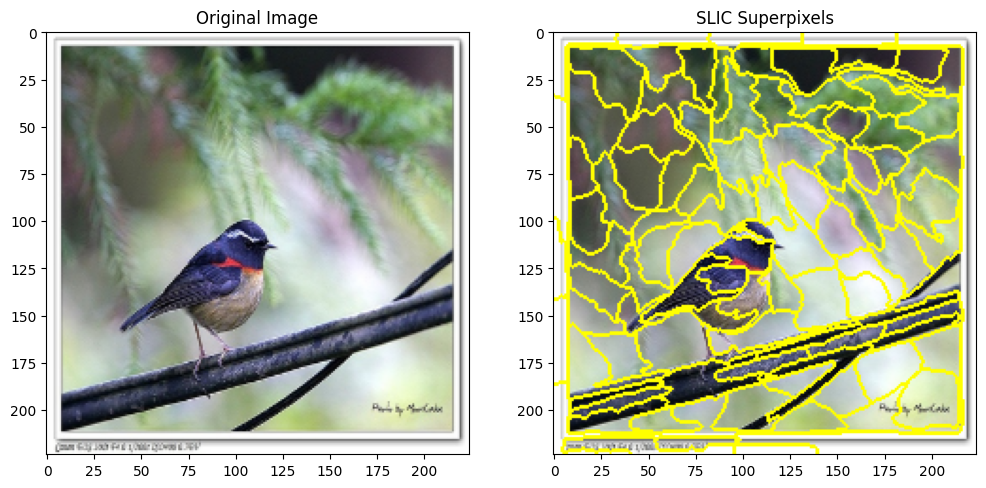

In [5]:
# Display the output
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(original_img)
ax[0].set_title('Original Image')
ax[1].imshow(mark_boundaries(original_img, segments_slice))
ax[1].set_title('SLIC Superpixels')
plt.show()


STEP-2 5D- SPECTRAL clustering

Extract features for each superpixel (mean values of L, a, b, mean positions of x-axis and y-axis).

In [6]:
from skimage import color
import numpy as np

# Convert image to Lab color space
lab_img = color.rgb2lab(original_img)

# Initialize arrays to hold the features of each superpixel
features = np.zeros((n_segments, 5))

# Calculate the spatial weight (SW)
H, W = original_img.shape[:2]
m = 100  # as per the given instruction
SW = np.sqrt(H * W) / m

# Extract features for each superpixel
for i in range(n_segments):
    mask = segments_slice == i
    superpixel = lab_img[mask]

    # Mean L, a, b values
    features[i, :3] = np.mean(superpixel, axis=0)

    # Mean x, y positions (normalized by SW)
    y_indices, x_indices = np.where(mask)
    features[i, 3] = np.mean(x_indices) / SW
    features[i, 4] = np.mean(y_indices) / SW

# Check for any NaN values in the features and handle them
# This will replace NaN with the mean of the respective feature column
nan_mask = np.isnan(features).any(axis=1)
features[nan_mask, :] = np.nanmean(features, axis=0)


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


STEP-3: Construct the nearest neighbor graph and define the similarity matrix

In [7]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

# Number of neighbors for the graph; small number 5
k_neighbors = 5

# Define a small epsilon value to prevent division by zero
eps = 1e-10

# Use NearestNeighbors from sklearn to find the nearest neighbors
nbrs = NearestNeighbors(n_neighbors=k_neighbors).fit(features)
distances, indices = nbrs.kneighbors(features)

# Initialize the similarity matrix with zeros
S = np.zeros((n_segments, n_segments))

# Compute sigma for each node
sigma = np.mean(distances[:, 1:k_neighbors], axis=1)/ np.sqrt(2)

# Compute the similarity matrix
for i in range(n_segments):
    for j in indices[i]:
        if i == j:
            continue
       # D_ij = np.linalg.norm(features[i] - features[j])
        # Calculate the 5-D Euclidean distance according to the formula
        L1, a1, b1, x1, y1 = features[i]
        L2, a2, b2, x2, y2 = features[j]
        D_ij = np.sqrt((L1 - L2)**2 + (a1 - a2)**2 + (b1 - b2)**2 + ((x1 - x2) / SW)**2 + ((y1 - y2) / SW)**2)

       # S[i, j] = np.exp(-D_ij**2 / (2 * sigma[i] * sigma[j]))  # Use both sigma_i and sigma_j
         # Use both sigma_i and sigma_j with epsilon to prevent division by zero
        S[i, j] = np.exp(-D_ij**2 / (2 * (sigma[i] + eps) * (sigma[j] + eps)))

# Since S should be symmetric, we can copy the upper triangle to the lower triangle
S = (S + S.T) / 2


STEP-4: Spectral clustering involves the following steps:

Compute the Laplacian matrix L of the similarity matrix.
Compute the eigenvalues and eigenvectors of L.
Use the eigenvectors corresponding to the smallest non-zero eigenvalues to represent the data in a lower-dimensional space.
Cluster the points in this new space using a clustering algorithm like k-means.

In [8]:
from scipy.sparse.csgraph import laplacian
from scipy.linalg import eigh
from sklearn.cluster import KMeans

# Step 1: Compute the Laplacian matrix
L = laplacian(S, normed=True)

# Step 2: Compute the eigenvalues and eigenvectors
eigenvalues, eigenvectors = eigh(L)

# Step 3: Select the top k eigenvectors
#For changing kvalue
k = 4
top_k_eigenvectors = eigenvectors[:, :k]  # Select the first k eigenvectors


# Step 4: Cluster the points using k-means
# Normalize the eigenvectors row-wise
X = top_k_eigenvectors / np.linalg.norm(top_k_eigenvectors, axis=1)[:, None]
kmeans = KMeans(n_clusters=k,n_init=10, random_state=42)
labels = kmeans.fit_predict(X)

# labels now contain the cluster labels for each superpixel


In [9]:
print("labels shape:", labels.shape)

labels shape: (112,)


#

```
# This is formatted as code
```

STEP-5: Visualisation of 5D spectral Clustering

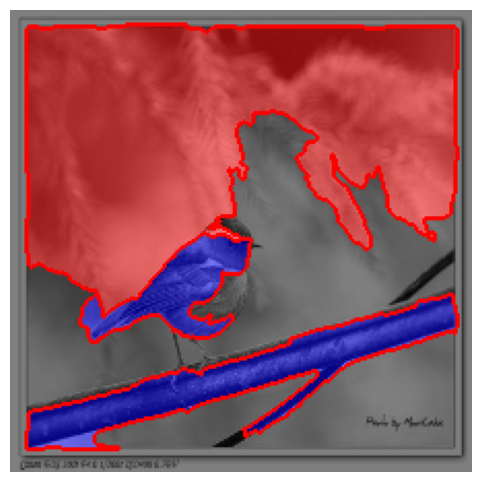

In [10]:
from skimage.segmentation import find_boundaries
from skimage.color import label2rgb

# Create a label image using the labels from spectral clustering
labeled_img = np.copy(segments_slice)
for i in range(0,n_segments):
    labeled_img[segments_slice == i] = labels[i]

# Use label2rgb to overlay the label colors onto the original image
label_overlay = label2rgb(labeled_img, image=original_img, alpha=0.5)

# Find boundaries between clusters
boundaries = find_boundaries(labeled_img, mode='thick')

# Overlay the boundaries: set them to red for visibility
overlay_with_boundaries = np.copy(label_overlay)
overlay_with_boundaries[boundaries] = [255, 0, 0]

# Display the result
plt.figure(figsize=(8, 6))
plt.imshow(overlay_with_boundaries)
plt.axis('off')  # Hide the axes
plt.show()


In [11]:
# Map cluster labels back to the image space based on the segments
label_map = np.zeros_like(segments_slice)

# Iterate over each unique segment ID
for segment_id in np.unique(segments_slice):
    # Create a mask for the current segment
    mask = segments_slice == segment_id

    if segment_id < len(labels):
        label_map[mask] = labels[segment_id]
    else:
        pass

In [12]:
# Map the cluster labels from 'labels' to the corresponding superpixels in 'segments_slic'
label_image = np.zeros_like(segments_slice)
for (superpixel_index, cluster_label) in enumerate(labels):
    label_image[segments_slice == superpixel_index] = cluster_label

# Now 'label_image' is a 2D array with the same dimensions as 'original_img'
# where each pixel's value is the cluster label of the superpixel it belongs to


In [13]:
import numpy as np

# Assuming 'labels' contains the cluster labels for each segment
total_unique_clusters = len(np.unique(labels))
print("Total number of unique clusters:", total_unique_clusters)


Total number of unique clusters: 4


For getting similar color bar of histogram match with image, writing this part of code

In [14]:
# Map cluster labels to the image space based on the segments
label_image = np.zeros_like(segments_slice)
for (superpixel_index, cluster_label) in enumerate(labels):
    label_image[segments_slice == superpixel_index] = cluster_label

In [15]:

# Count the occurrences of each unique label
unique_labels, counts = np.unique(label_image, return_counts=True)

# Extract colors from label_overlay
colors = {label: label_overlay[label_image == label][0] for label in unique_labels}




In [16]:
# # Create the histogram
# plt.figure(figsize=(12, 8))
# for label, count in zip(unique_labels, counts):
#     plt.bar(label, count, color=colors[label])

# # Labeling the plot
# plt.xlabel('Cluster Label')
# plt.ylabel('Area (number of superpixels)')
# plt.title('Histogram of Cluster Areas')
# plt.xticks(unique_labels)  # Ensure all cluster labels are shown as ticks
# plt.show()

Create a histogram bar for each unique color of the region in image

<ipython-input-17-6cd35ae02f79>:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('nipy_spectral', len(unique_labels))  # Use 'nipy_spectral' or any other suitable colormap


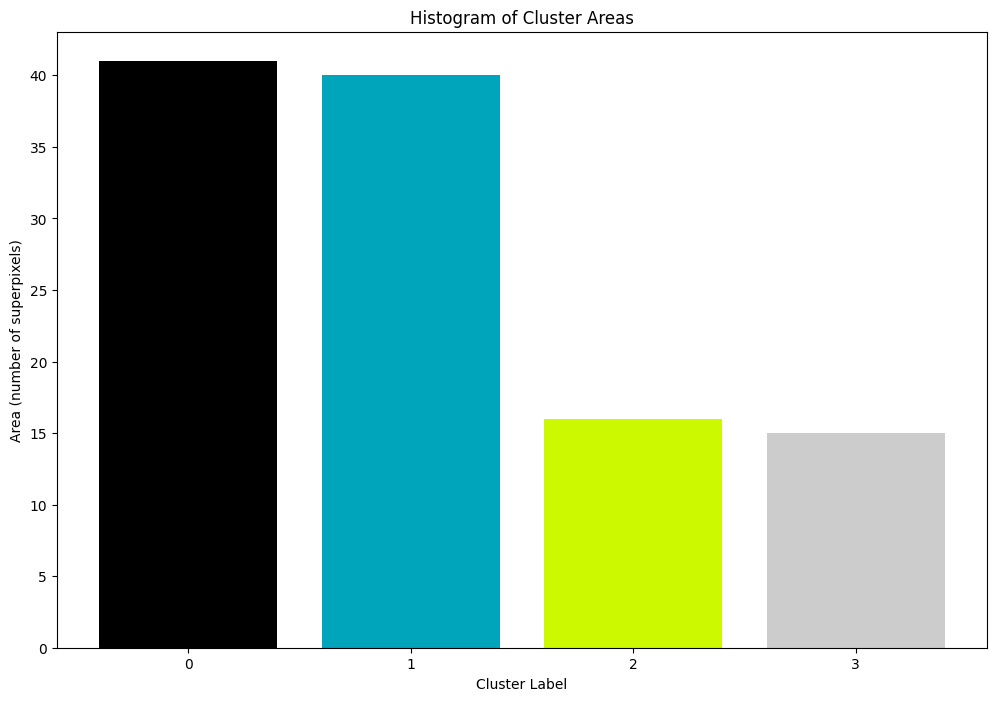

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'label_image' is the result of mapping SLIC segments to 5D spectral clustering labels

# Count the occurrences of each unique label to find the area each cluster occupies
unique_labels, counts = np.unique(labels, return_counts=True)

# Generate a colormap and assign a unique color to each bar/cluster
cmap = plt.cm.get_cmap('nipy_spectral', len(unique_labels))  # Use 'nipy_spectral' or any other suitable colormap

# Create the histogram
plt.figure(figsize=(12, 8))
for i, (label, count) in enumerate(zip(unique_labels, counts)):
    plt.bar(label, count, color=cmap(i))

# Labeling the plot
plt.xlabel('Cluster Label')
plt.ylabel('Area (number of superpixels)')
plt.title('Histogram of Cluster Areas')
plt.xticks(unique_labels)  # Ensure all cluster labels are shown as ticks

# Show the plot
plt.show()


To compute the percentage of the image each bar occupies here we have used the total number of pixels in the image

In [18]:
# Total number of pixels in the image
total_pixels = original_img.shape[0] * original_img.shape[1]

# Calculate the percentage of each bar
cluster_percentages = (counts / total_pixels) * 100

# Normalize the values to sum up to 100 and round to 2 decimal places
normalized_percentages = np.round((cluster_percentages / np.sum(cluster_percentages)) * 100, 2)

# Check if the sum is 100 after rounding, if not, adjust the last element to make the sum 100
if np.sum(normalized_percentages) != 100:
    difference = 100 - np.sum(normalized_percentages)
    normalized_percentages[-1] += difference

print(normalized_percentages)
Area_percentages = normalized_percentages

[36.61 35.71 14.29 13.39]


In [19]:
# #### New Computation ############3

out =(normalized_percentages / 100)
prob = (1-out)
probabilities = np.where(out > 0.2, 0.5, np.round(prob, 2))
print(probabilities)

[0.5  0.5  0.86 0.87]


In [20]:
# cluster labels as keys and probabilities as values
cluster_probability_dict = {cluster_label: probability for cluster_label, probability in zip(range(0, k+1 ), probabilities)}

#Create the  formatted
cluster_probability = {"cluster " + str(cluster_label): probability for cluster_label, probability in cluster_probability_dict.items()}

# Print the result
print(cluster_probability)


{'cluster 0': 0.5, 'cluster 1': 0.5, 'cluster 2': 0.86, 'cluster 3': 0.87}


############## Saliency Map Generation Method ##########

In [21]:

import os
import numpy as np
from matplotlib import pyplot as plt
from skimage.transform import resize
from tqdm import tqdm
from keras.preprocessing import image
import random

In [22]:
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras import backend as K

In [26]:
class Model():
    def __init__(self):
        #K.set_learning_phase(0)
        self.model = ResNet50()
        self.input_size = (224, 224)

    def run_on_batch(self, x):
        return self.model.predict(x)

In [27]:
model = Model()

102967424/102967424 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


In [28]:
def class_name(idx):
    return decode_predictions(np.eye(1, 1000, idx))[0][0][1]

In [29]:
def load_img(path):
    img = image.load_img(path, target_size=model.input_size)
    x = image.img_to_array(img)
    #x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

In [30]:
# Define probabilities for each cluster
probabilities = cluster_probability
print(probabilities)

{'cluster 0': 0.5, 'cluster 1': 0.5, 'cluster 2': 0.86, 'cluster 3': 0.87}


Mask Creation Step

Based on superpixels

In [31]:
def generate_segment_masks(clusters, segments, probabilities):
    unique_segments = np.unique(segments)
    segment_clusters = {}

    # Adjusted approach to handle segment to cluster mapping
    for segment_id in unique_segments:
        # Directly use 'segment_id' to find corresponding label if 'clusters' is indexed by 'segment_id'
        if segment_id < len(clusters):
            common_label = clusters[segment_id]
        else:
            continue  # Skip if 'segment_id' exceeds the bounds of 'clusters'
        segment_clusters[segment_id] = common_label

    # The rest of the function remains the same...
    # Initialize an empty mask
    mask = np.zeros_like(segments, dtype=float)

    # Iterate over each cluster to determine which segments to activate based on probability
    for cluster_id, probability in probabilities.items():
        # Extract all segments belonging to the current cluster
        cluster_segments = [segment for segment, cluster in segment_clusters.items() if int(cluster) == int(cluster_id.split(' ')[1])]

        # Determine the number of segments to activate based on the cluster probability
        num_segments_to_activate = int(round(probability * len(cluster_segments)))

        # Randomly select segments to activate
        activated_segments = random.sample(cluster_segments, num_segments_to_activate)

        # Mark the selected segments as 1 in the mask
        for segment in activated_segments:
            mask[segments == segment] = 1

    return mask


In [32]:
result_masks = generate_segment_masks(labels, segments_slice, probabilities)

(224, 224)


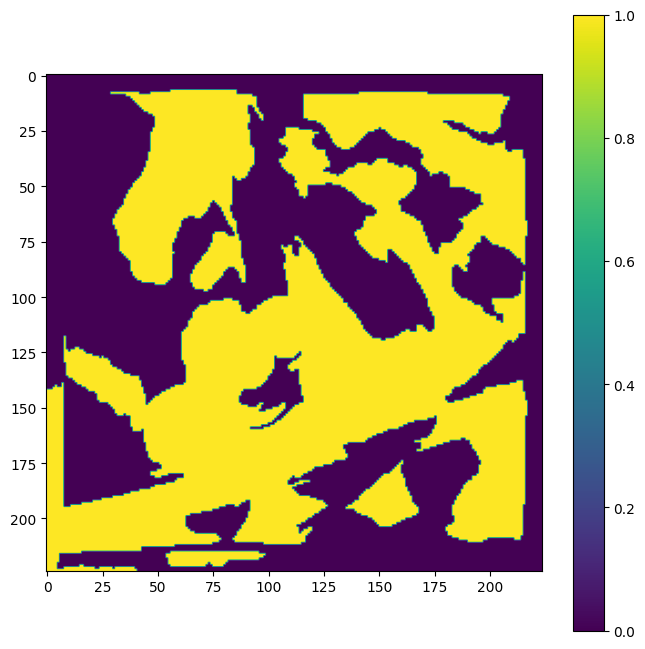

In [33]:
print(result_masks.shape)
plt.figure(figsize=(8, 8))
plt.imshow(result_masks)
plt.colorbar()

In [34]:
# No ofmask
N= 256
masks = np.array([generate_segment_masks(labels, segments_slice, probabilities) for _ in range(N)])
print(masks.shape)


(256, 224, 224)


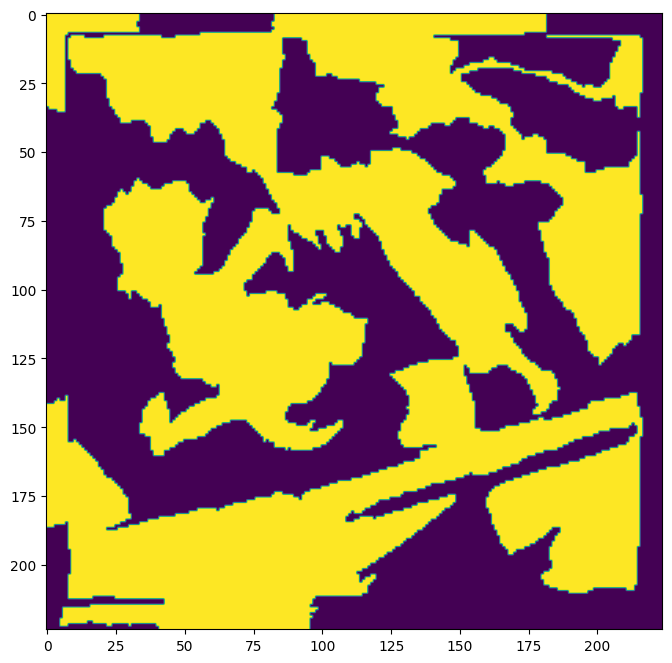

In [35]:
plt.figure(figsize=(8, 8))
plt.imshow(masks[3])

In [36]:

# image_path = '/content/drive/MyDrive/Colab Notebooks/New-Project/gil.jpg'

In [37]:
image_path = '/content/drive/MyDrive/Colab Notebooks/New-Project/PASCAL-DATASET/JPEGImages/000236.jpg'

In [38]:
img, x = load_img(image_path)

In [39]:
batch_size = 50

def explain(model, x, masks):
    preds = []

    masked = np.empty((N, *x.shape))

    for i in range(N):
              masked[i] = x* masks[i, :, :, np.newaxis]
              plt.imshow(masked[3])
    masked

    for i in tqdm(range(0, N, batch_size), desc='Explaining'):
        preds.append(model.run_on_batch(masked[i:min(i+batch_size, N)]))
    preds = np.concatenate(preds)
    sal = preds.T.dot(masks.reshape(N, -1)).reshape(-1, *model.input_size)
    sal = sal / N
    return sal

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

batch_size = 50

def explain(model, x, masks):
    N = masks.shape[0]  # Assuming N is the number of masks
    preds = []
    masked = np.empty((N, *x.shape), dtype=x.dtype)  # Ensure the data type matches the input

    for i in range(N):
        masked[i] = x * masks[i, :, :, np.newaxis]
        if masked[i].dtype == np.float32 or masked[i].dtype == np.float64:
            masked[i] = (masked[i] - np.min(masked[i])) / (np.max(masked[i]) - np.min(masked[i]))
        #if i == 5:  # Displaying only for the 3rd mask as an example
            #plt.imshow(masked[i],cmap='gray')
            #plt.show()

    for i in tqdm(range(0, N, batch_size), desc='Explaining'):
        preds.append(model.run_on_batch(masked[i:i + batch_size]))

    preds = np.concatenate(preds)
    sal = preds.T.dot(masks.reshape(N, -1)).reshape(-1, *model.input_size)
    sal = sal / N
    return sal


In [41]:
sal = explain(model,x, masks)

Explaining:   0%|          | 0/6 [00:00<?, ?it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 6s/step


Explaining:  17%|█▋        | 1/6 [00:20<01:43, 20.63s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Explaining:  33%|███▎      | 2/6 [00:21<00:34,  8.72s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Explaining:  50%|█████     | 3/6 [00:21<00:14,  4.91s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Explaining:  67%|██████▋   | 4/6 [00:21<00:06,  3.06s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Explaining:  83%|████████▎ | 5/6 [00:21<00:02,  2.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Explaining: 100%|██████████| 6/6 [00:25<00:00,  4.19s/it]


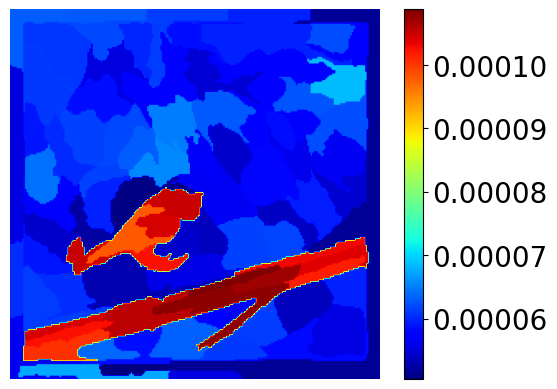

In [42]:
class_idx = 16
#plt.title('Explanation for `{}`'.format(class_name(class_idx)))
plt.axis('off')
plt.imshow(img)
saliency = sal[class_idx]
#plt.imshow(saliency, cmap='jet')
#plt.colorbar()

cmap = plt.imshow(saliency, cmap='jet')
colorbar = plt.colorbar(cmap)

# Set the colorbar tick label font size.
colorbar.ax.tick_params(labelsize=20)
plt.show()

Evaluation Metrics: Insertion and Deletion Score

In [43]:
%cd /content/drive/MyDrive/Colab Notebooks/New-Project

/content/drive/MyDrive/Colab Notebooks/New-Project


In [44]:
###### Importing libraries##########
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torchvision.datasets as datasets
import torchvision.models as models
from torch.nn.functional import conv2d
cudnn.benchmark = True

In [45]:
from evaluation import CausalMetric, auc, gkern
from utils import *

In [46]:
# Load black box model for explanations
model = models.resnet50(True)
model = nn.Sequential(model, nn.Softmax(dim=1))
model = model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

for p in model.parameters():
    p.requires_grad = False

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 171MB/s]


Prepare substrate function

In [47]:
klen = 11
ksig = 5
kern = gkern(klen, ksig)

# Function that blurs input image
blur = lambda x: nn.functional.conv2d(x, kern, padding=klen//2)

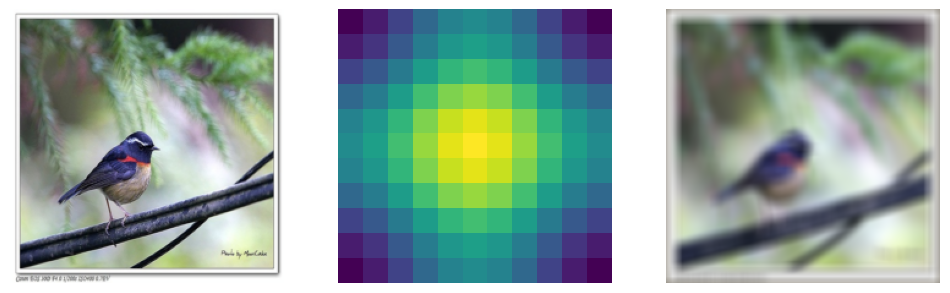

In [48]:
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.axis('off')
#img = read_tensor('/content/drive/MyDrive/Colab Notebooks/New-Project/eagle.jpg')
img = read_tensor('/content/drive/MyDrive/Colab Notebooks/New-Project/PASCAL-DATASET/JPEGImages/000236.jpg')
#img = read_tensor('gil.jpg')
tensor_imshow(img[0])

plt.subplot(132)
plt.axis('off')
plt.imshow(kern[0, 0])

plt.subplot(133)
plt.axis('off')
tensor_imshow(blur(img)[0])
plt.show()

In [49]:
######### Causal Metrics #######
insertion = CausalMetric(model, 'ins', 224, substrate_fn=blur)
deletion = CausalMetric(model, 'del', 224, substrate_fn=torch.zeros_like)

########### Evaluating Metrics for Single Image #######

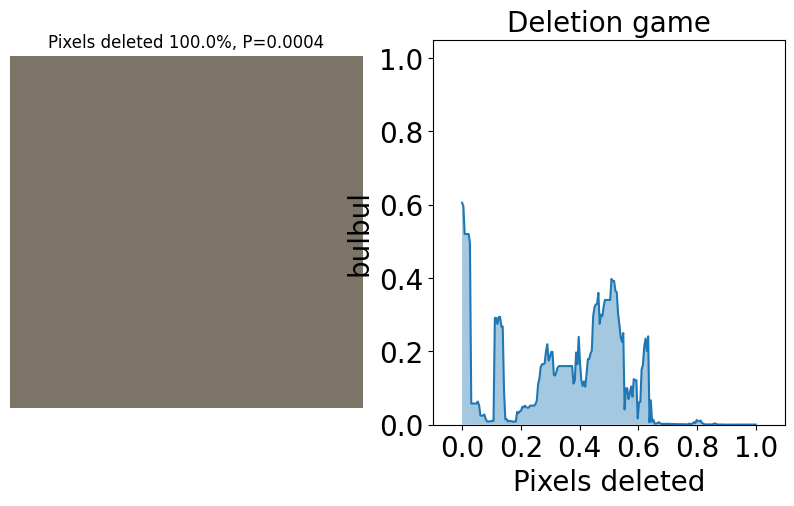

AUC: 0.10710273753199674


In [50]:
h = deletion.single_run(img, sal, verbose=1)

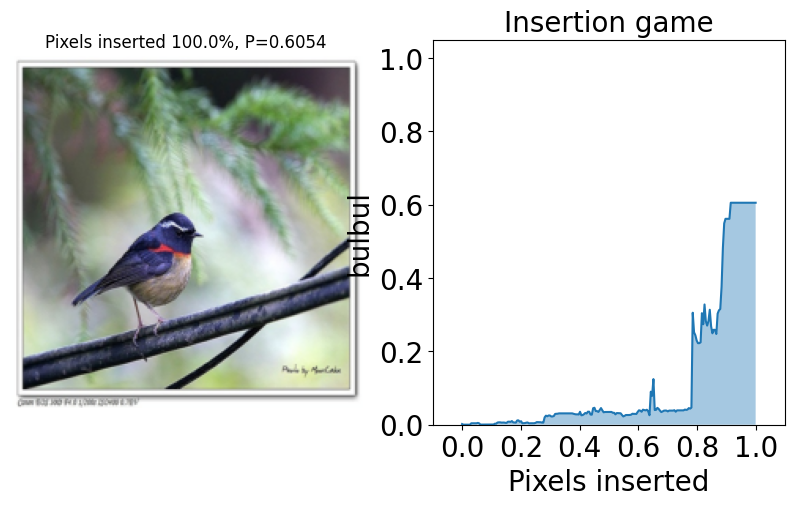

AUC: 0.11470127021584631


In [51]:
h = insertion.single_run(img, sal, verbose=1)

# New Evaluation Metric: DTI and DTD

Processing the imput image

In [52]:
target_class_idx = 16

In [53]:
import torchvision.transforms as transforms
from PIL import Image

# Function to load and preprocess the original image
def load_and_preprocess_image(image_path):
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    image = Image.open(image_path).convert('RGB')
    image_tensor = preprocess(image).unsqueeze(0).to(device)

    return image_tensor

# Load and preprocess the original image
original_image_tensor = load_and_preprocess_image('/content/drive/MyDrive/Colab Notebooks/New-Project/PASCAL-DATASET/JPEGImages/000236.jpg') # Replace with your image path


In [54]:
# Model_predict function to take a PyTorch tensor as input
def model_predict(image_tensor, target_class_idx):
    # Make sure the tensor is on the correct device
    image_tensor = image_tensor.to(device)

    # Get the model's output
    with torch.no_grad():
        output = model(image_tensor)

    # Extract the probability for the target class
    probability = output.cpu().numpy()[0][target_class_idx]
    #print(probability)
    return probability


In [55]:
def get_image_mean_values():
    return [0.485, 0.456, 0.406]

With the replacement of mean value

In [56]:
def remove_pixels_by_saliency(original_image_tensor, saliency_map, threshold):
    # Flatten and normalize the saliency map to the range [0, 1]
    flat_saliency_map = saliency_map.flatten()
    normalized_saliency = flat_saliency_map / flat_saliency_map.max()

    #print("normalized_saliency",normalized_saliency)

    # Create a mask for pixels to remove (True for keeping, False for removing)
    mask = normalized_saliency < threshold

    #print("boolean mask value",mask)

    # Reshape the mask to match the spatial dimensions of the original image tensor
    mask = mask.reshape(original_image_tensor.shape[2:])

    # The mask needs to be applied across all channels, so replicate the mask for each channel
    mask_replicated_across_channels = torch.repeat_interleave(torch.tensor(mask, dtype=torch.bool).unsqueeze(0), original_image_tensor.size(1), dim=0)

    # Ensure the mask tensor is on the same device as the original image tensor
    mask_tensor = mask_replicated_across_channels.to(original_image_tensor.device)

    # Clone the original image tensor for modification
    modified_image_tensor = original_image_tensor.clone()

    # Prepare a tensor of mean values for replacement where the mask is False
    mean_values_tensor = torch.tensor(get_image_mean_values(), device=original_image_tensor.device).view(1, 3, 1, 1)

    # Expand mean values tensor to match the dimensions of the image tensor
    expanded_mean_values = mean_values_tensor.expand_as(original_image_tensor)

    #print("means values which is used for replacement",expanded_mean_values)

    # Apply the mask: Replace pixels where the mask is False with the mean values
    modified_image_tensor[:, ~mask_tensor] = expanded_mean_values[:, ~mask_tensor]

    #print("modified value after deleting every important pixel", modified_image_tensor)
    return modified_image_tensor


In [57]:
# Initialize variables to hold the results
model_confidences = []
thresholds_used = []  # This will store the thresholds used at each step

# Perform the perturbation analysis
for current_threshold in np.arange(1.0, 0.0, -0.01):

    # Remove pixels based on the current threshold
    modified_image_tensor = remove_pixels_by_saliency(original_image_tensor, saliency, current_threshold)

    # Get the model's prediction for the modified image
    confidence = model_predict(modified_image_tensor, target_class_idx)

    # Store the model's confidence
    model_confidences.append(confidence)

    # Record the threshold used
    thresholds_used.append(current_threshold)  # Add the current threshold to the list

print(thresholds_used)
print(model_confidences)


[1.0, 0.99, 0.98, 0.97, 0.96, 0.95, 0.94, 0.9299999999999999, 0.9199999999999999, 0.9099999999999999, 0.8999999999999999, 0.8899999999999999, 0.8799999999999999, 0.8699999999999999, 0.8599999999999999, 0.8499999999999999, 0.8399999999999999, 0.8299999999999998, 0.8199999999999998, 0.8099999999999998, 0.7999999999999998, 0.7899999999999998, 0.7799999999999998, 0.7699999999999998, 0.7599999999999998, 0.7499999999999998, 0.7399999999999998, 0.7299999999999998, 0.7199999999999998, 0.7099999999999997, 0.6999999999999997, 0.6899999999999997, 0.6799999999999997, 0.6699999999999997, 0.6599999999999997, 0.6499999999999997, 0.6399999999999997, 0.6299999999999997, 0.6199999999999997, 0.6099999999999997, 0.5999999999999996, 0.5899999999999996, 0.5799999999999996, 0.5699999999999996, 0.5599999999999996, 0.5499999999999996, 0.5399999999999996, 0.5299999999999996, 0.5199999999999996, 0.5099999999999996, 0.49999999999999956, 0.48999999999999955, 0.47999999999999954, 0.46999999999999953, 0.459999999999

In [58]:
# Ensure thresholds_used is a numpy array for processing
thresholds_array = np.array(thresholds_used)

# Calculate the area under the model confidence curve as a function of saliency threshold
# This will give us an indication of how model confidence changes as more salient pixels are removed
area_under_confidence_curve = np.trapz(model_confidences, thresholds_array)

# Normalize the area by the range of thresholds to get the average drop in confidence
# This normalization makes the metric independent of the number of steps or the exact range of thresholds used
average_drop_in_confidence = area_under_confidence_curve / (thresholds_array[-1] - thresholds_array[0])

print(f"Average drop in model confidence per unit increase in saliency threshold: {average_drop_in_confidence}")
#print(area_under_confidence_curve )



Average drop in model confidence per unit increase in saliency threshold: 0.08072818491773706


In [59]:
import matplotlib.pyplot as plt
import numpy as np

# The `thresholds_array` and `model_confidences_array` are numpy arrays
# They are in descending order, we need to be reversed for correct plotting and AUC calculation
thresholds_array = np.array(thresholds_used)[::-1]  # Reverse the thresholds array
model_confidences_array = np.array(model_confidences)[::-1]  # Reverse the model confidences array

# Recalculate AUC with the arrays in ascending order
area_under_confidence_curve = np.trapz(model_confidences_array, thresholds_array)

# Normalize the area by the range of thresholds
roc_auc = area_under_confidence_curve / (thresholds_array[-1] - thresholds_array[0])



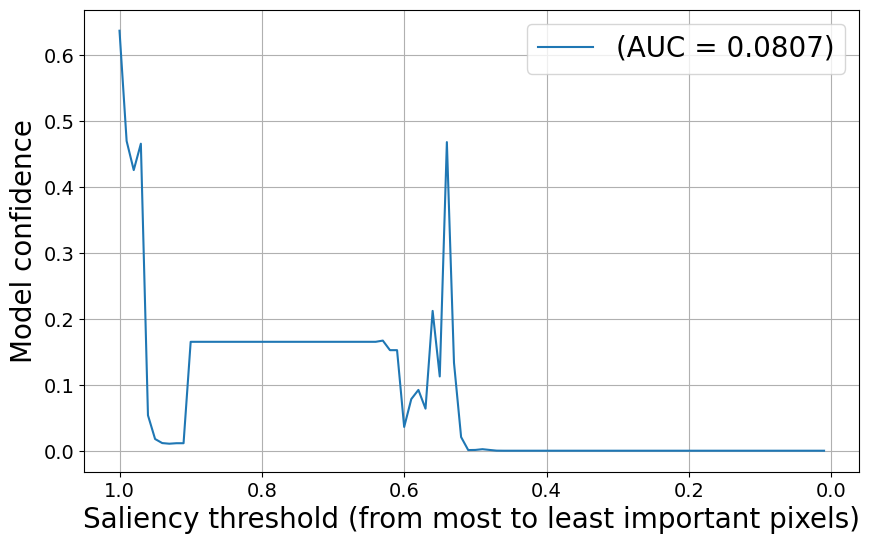

The Area Under the Curve is: 0.0807


In [60]:
import matplotlib.pyplot as plt
import numpy as np

# thresholds_array and model_confidences_array are defined and filled with data
# roc_auc is calculated and holds the AUC value

# Set font sizes
plt.rcParams.update({'font.size': 14})  # Adjusts the font size of all plot elements
label_fontsize = 20  # Font size for x and y labels
legend_fontsize = 20  # Font size for the legend

# Plot the Model Confidence Curve using the thresholds and model confidences
plt.figure(figsize=(10, 6))
plt.plot(thresholds_array, model_confidences_array, label=f'(AUC = {roc_auc:.4f})')
#plt.title('Model Confidence as Salient Pixels are Removed', fontsize=title_fontsize)
plt.xlabel('Saliency threshold (from most to least important pixels)', fontsize=label_fontsize)
plt.ylabel('Model confidence', fontsize=label_fontsize)
plt.legend(fontsize=legend_fontsize)
plt.grid(True)
plt.gca().invert_xaxis()  # Invert the x-axis to show decreasing thresholds from left to right
plt.show()

print(f"The Area Under the Curve is: {roc_auc:.4f}")


New Insertion Method design

In [61]:
def add_pixels_by_saliency(original_image_tensor, saliency_map, threshold):
    # Flatten and normalize the saliency map to the range [0, 1]
    flat_saliency_map = saliency_map.flatten()
    normalized_saliency = flat_saliency_map / flat_saliency_map.max()

    # Create a mask for pixels to remove (True for keeping, False for removing)
    mask = normalized_saliency >= threshold

    # Reshape the mask to match the spatial dimensions of the original image tensor
    mask = mask.reshape(original_image_tensor.shape[2:])

    # The mask needs to be applied across all channels, so replicate the mask for each channel
    mask_replicated_across_channels = torch.repeat_interleave(torch.tensor(mask, dtype=torch.bool).unsqueeze(0), original_image_tensor.size(1), dim=0)

    # Ensure the mask tensor is on the same device as the original image tensor
    mask_tensor = mask_replicated_across_channels.to(original_image_tensor.device)

    # Clone the original image tensor for modification
    modified_image_tensor = original_image_tensor.clone()

    # Set the pixels where the mask is False (salient pixels above the threshold) to zero
    modified_image_tensor[:, ~mask_tensor] = 0

    return modified_image_tensor


In [62]:
# Initialize variables to hold the results
model_confidences = []
thresholds_used = []  # This will store the thresholds used at each step

# Perform the perturbation analysis
for current_threshold in np.arange(1.0, 0.0, -0.01):

    # Remove pixels based on the current threshold
    modified_image_tensor = add_pixels_by_saliency(original_image_tensor, saliency, current_threshold)

    # Get the model's prediction for the modified image
    confidence = model_predict(modified_image_tensor, target_class_idx)

    # Store the model's confidence
    model_confidences.append(confidence)

    # Record the threshold used
    thresholds_used.append(current_threshold)  # Add the current threshold to the list

print(thresholds_used)
print(model_confidences)


[1.0, 0.99, 0.98, 0.97, 0.96, 0.95, 0.94, 0.9299999999999999, 0.9199999999999999, 0.9099999999999999, 0.8999999999999999, 0.8899999999999999, 0.8799999999999999, 0.8699999999999999, 0.8599999999999999, 0.8499999999999999, 0.8399999999999999, 0.8299999999999998, 0.8199999999999998, 0.8099999999999998, 0.7999999999999998, 0.7899999999999998, 0.7799999999999998, 0.7699999999999998, 0.7599999999999998, 0.7499999999999998, 0.7399999999999998, 0.7299999999999998, 0.7199999999999998, 0.7099999999999997, 0.6999999999999997, 0.6899999999999997, 0.6799999999999997, 0.6699999999999997, 0.6599999999999997, 0.6499999999999997, 0.6399999999999997, 0.6299999999999997, 0.6199999999999997, 0.6099999999999997, 0.5999999999999996, 0.5899999999999996, 0.5799999999999996, 0.5699999999999996, 0.5599999999999996, 0.5499999999999996, 0.5399999999999996, 0.5299999999999996, 0.5199999999999996, 0.5099999999999996, 0.49999999999999956, 0.48999999999999955, 0.47999999999999954, 0.46999999999999953, 0.459999999999

In [63]:
# Ensure thresholds_used is a numpy array for processing
thresholds_array = np.array(thresholds_used)

# Calculate the area under the model confidence curve as a function of saliency threshold
# This will give us an indication of how model confidence changes as more salient pixels are removed
area_under_confidence_curve = np.trapz(model_confidences, thresholds_array)

# Normalize the area by the range of thresholds to get the average drop in confidence
# This normalization makes the metric independent of the number of steps or the exact range of thresholds used
average_inc_in_confidence = area_under_confidence_curve / (thresholds_array[-1] - thresholds_array[0])

print(f"Average increase in model confidence per unit increase in saliency threshold: {average_inc_in_confidence}")
#print(area_under_confidence_curve )



Average increase in model confidence per unit increase in saliency threshold: 0.29041457662709164


In [64]:
import matplotlib.pyplot as plt
import numpy as np

# The `thresholds_array` and `model_confidences_array` are numpy arrays
# They are in descending order, we need to be reversed for correct plotting and AUC calculation
thresholds_array = np.array(thresholds_used)[::-1]  # Reverse the thresholds array
model_confidences_array = np.array(model_confidences)[::-1]  # Reverse the model confidences array

# Recalculate AUC with the arrays in ascending order
area_under_confidence_curve = np.trapz(model_confidences_array, thresholds_array)

# Normalize the area by the range of thresholds
roc_auc = area_under_confidence_curve / (thresholds_array[-1] - thresholds_array[0])



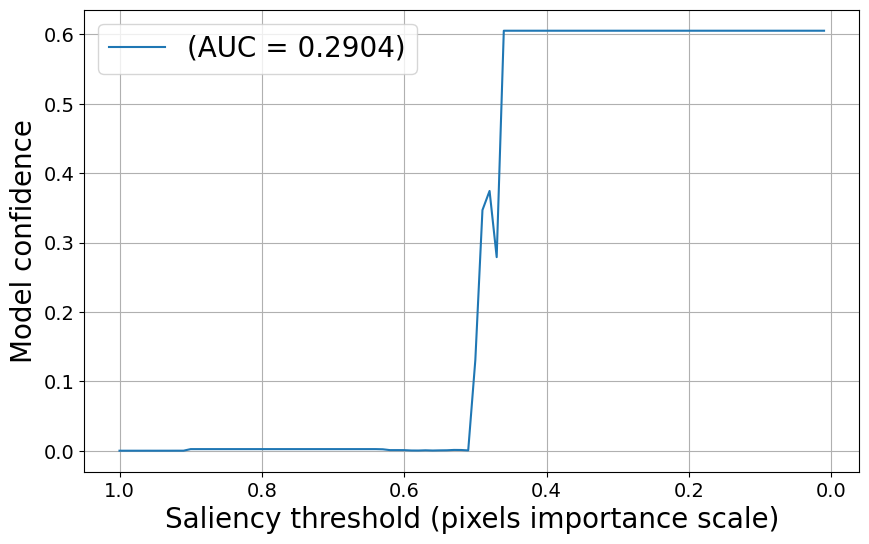

The Area Under the Curve is: 0.2904


In [65]:
import matplotlib.pyplot as plt
import numpy as np

# thresholds_array and model_confidences_array are defined and filled with data
# roc_auc is calculated and holds the AUC value

# Set font sizes
plt.rcParams.update({'font.size': 14})  # Adjusts the font size of all plot elements
label_fontsize = 20  # Font size for x and y labels
legend_fontsize = 20  # Font size for the legend

# Plot the Model Confidence Curve using the thresholds and model confidences
plt.figure(figsize=(10, 6))
plt.plot(thresholds_array, model_confidences_array, label=f'(AUC = {roc_auc:.4f})')
#plt.title('Model Confidence as Salient Pixels are Removed', fontsize=title_fontsize)
plt.xlabel('Saliency threshold (pixels importance scale)', fontsize=label_fontsize)
plt.ylabel('Model confidence', fontsize=label_fontsize)
plt.legend(fontsize=legend_fontsize)
plt.grid(True)
plt.gca().invert_xaxis()  # Invert the x-axis to show increasing thresholds from left to right
plt.show()

print(f"The Area Under the Curve is: {roc_auc:.4f}")
